In [24]:
#%reset -f
import os
%matplotlib inline 

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as spstats
import warnings
import os
import string
import sklearn

from sklearn                          import  tree, svm, ensemble, neighbors, linear_model, metrics, preprocessing, datasets
from sklearn.preprocessing            import Imputer,LabelEncoder, OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.cross_validation         import train_test_split
from sklearn.model_selection          import train_test_split,KFold,cross_val_score

from sklearn.ensemble                 import RandomForestClassifier
from sklearn.metrics                  import accuracy_score, classification_report, confusion_matrix,roc_curve,mean_squared_error,mean_absolute_error,r2_score,roc_auc_score,recall_score
from time                             import time


In [6]:
pwd = os.getcwd()  #pwd: Print Working Directory
print("*"*50)
print ('Current working directory:  %s' %pwd)
print("*"*50)
df_orig = pd.read_csv('ContainerModelData.csv')
df=df_orig
print("The data is loaded in df")
print("*"*50)
print(df.shape)

**************************************************
Current working directory:  C:\Users\viveksi\Google Drive\Machine Learning Courses\Viv_own_ML\PA_ContainerRecoEnginer
**************************************************
The data is loaded in df
**************************************************
(661, 28)


In [7]:
## CleanUp
df = df[df['AVG_30_MIN']>=0]
df = df[df['DIST']>=0]
df = df.drop(['GKEY','TRUCK_ENTERED','EDATE','EXITED','PICK_YARD_POS','DROP_POS','RTG','HAD_TROUBLE'],axis=1)

In [8]:
# We can clip these outliers
df_clipped = df[df['TT_MIN'] <=180]
print ('Rows & Columns: ',df_clipped.shape)

Rows & Columns:  (655, 20)


## Encoding

In [16]:
categorical_cols =['PICK_ROW_NBR']
df_encoded =pd.get_dummies(df_clipped, columns=categorical_cols, prefix=categorical_cols)

In [17]:
print("*"*50)
print ('Rows & Columns: ',df_encoded.shape)
print("*"*50)
df_encoded=df_encoded.round(decimals=0) # rounding weights
df_encoded.head()

**************************************************
Rows & Columns:  (655, 24)
**************************************************


,PHOUR,tv_trans_count,DROP_POS_ID,DIST,DROP_ROW_NBR,DROP_POS_ID_FLD,DROP_POS_FLD,DIST_FLD,DROP_ROW_NBR_FLD,TT_MIN,...,TOT,TRK_IN_ROW,TIER,AVG_30_MIN,RTG_Count,PICK_ROW_NBR_H,PICK_ROW_NBR_I,PICK_ROW_NBR_J,PICK_ROW_NBR_K,PICK_ROW_NBR_L
0,11,2,381F2.B,262,F,381F3.C,381,272,F,18,...,9,29,2,30.0,2,0,0,0,0,1
1,9,2,430M8.B,302,M,430M10.B,430,312,M,8,...,4,32,3,30.0,5,0,1,0,0,0
2,10,2,122B4.D,606,B,122B4.C,122,616,B,8,...,5,34,2,26.0,5,0,1,0,0,0
3,10,2,426E3.B,156,E,426E3.C,426,166,E,8,...,5,39,2,40.0,4,0,0,0,0,1
4,11,2,122B1.B,502,B,122B2.B,122,512,B,19,...,10,31,1,31.0,2,0,0,0,0,1


In [18]:
### Remove TT_MIN
df_encoded = df_encoded.drop(['TT_MIN','DROP_ROW_NBR','PHOUR','RTG_Count','DROP_POS_ID','DROP_POS_ID_FLD','DROP_POS_FLD','DIST_FLD','DROP_ROW_NBR_FLD'],axis=1)


## Split Train and Test Data

In [19]:
X = df_encoded.drop('TGT_TT',axis=1)
y = df_encoded['TGT_TT']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 123)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

(524, 14) (524,)
(131, 14) (131,)


## Feature Scaling

In [21]:
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

In [25]:
model = RandomForestClassifier(n_estimators=60, random_state=12,max_depth=15,min_samples_split=15)
model.fit(X_train, y_train)
model_pred =(model.predict(X_test))
print("*"*50)
print('Accuracy: ',accuracy_score(y_test,model_pred))
print("*"*50)
print('Confusion Matrix:')
print(confusion_matrix(y_test,model_pred))
print("*"*50)
print('Classification Report:')
print(classification_report(y_test,model_pred))
print("*"*50)

**************************************************
Accuracy:  0.44274809160305345
**************************************************
Confusion Matrix:
[[20 28  2]
 [14 18 10]
 [ 8 11 20]]
**************************************************
Classification Report:
             precision    recall  f1-score   support

          1       0.48      0.40      0.43        50
          2       0.32      0.43      0.36        42
          3       0.62      0.51      0.56        39

avg / total       0.47      0.44      0.45       131

**************************************************


Feature importance:
1) TRK_IN_ROW : 100
2) TOT : 94
3) AVG_30_MIN : 89
4) DIST : 82
5) TRK_OPP : 70
6) ROW_Feature : 63
7) TRK_IN_BTW : 56
8) TIER : 22
9) PICK_ROW_NBR_J : 19
10) PICK_ROW_NBR_I : 15
11) PICK_ROW_NBR_K : 11
12) PICK_ROW_NBR_L : 5
13) PICK_ROW_NBR_H : 3
14) tv_trans_count : 0


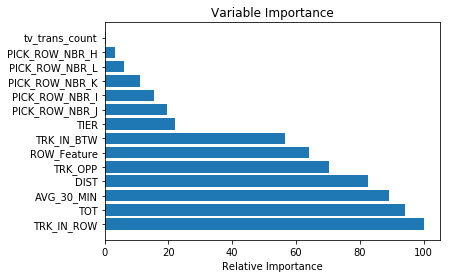

In [26]:
feature_importance = model.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)[::-1]
print ("Feature importance:")
i=1
for f,w in zip(X.columns[sorted_idx], feature_importance[sorted_idx]):
    print ("%d) %s : %d" % (i, f, w))
    i+=1
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1,1,1)
nb_to_display = 30
plt.barh(pos[:nb_to_display], feature_importance[sorted_idx][:nb_to_display], align='center')
plt.yticks(pos[:nb_to_display], X.columns[sorted_idx][:nb_to_display])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()